# Red neuronal Matemática 3

In [75]:
#Datos sacados de https://www.kaggle.com/datasets/fatemehmehrparvar/obesity-levels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("E:/Users/infolab/Desktop/tp-mate3-red/mate3-red/acv.csv")

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [76]:
print(df.isnull().sum()) #Chequeo presencia de valores nulos


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [77]:
gender_rep = { #Género
    "Female": 0,
    "Male": 1,
    "Other": 2, 
}

ever_married_rep = { #Alguna vez estuvo casado
    "No": 0,
    "Yes": 1,
}

work_type_rep =  { # Tipo de trabajo
    "Private": 0,
    "Self-employed": 1,
    "children": 2,
    "Never_worked": 3,
}

Residence_type_rep = { # Tipo de residencia
    "Urban": 0,
    "Rural": 1,
}

smoking_status_rep = { #Estatus como fumador
    "Unknown": 0,
    "never smoked": 1,
    "formerly smoked": 2,
    "smokes": 3,
}



In [78]:
df['gender'] = df['gender'].map(gender_rep)
df['ever_married'] = df['ever_married'].map(ever_married_rep)
df['work_type'] = df['work_type'].map(work_type_rep)
df['Residence_type'] = df['Residence_type'].map(Residence_type_rep)
df['smoking_status'] = df['smoking_status'].map(smoking_status_rep)

#Asignamos los valores numéricos a las columnas correspondientes.

In [79]:
df.dropna(axis=0, inplace=True) #Elimíno los NaN
df.drop("id", axis=1, inplace=True) #Elimíno columna id

In [80]:
print(df.head()) #Visualizo el dataframe con los nuevos valores
print(df.isnull().sum()) #Verifico valores nulos

   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1        0.0   
2       1  80.0             0              1             1        0.0   
3       0  49.0             0              0             1        0.0   
4       0  79.0             1              0             1        1.0   
5       1  81.0             0              0             1        0.0   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               0             228.69  36.6               2       1  
2               1             105.92  32.5               1       1  
3               0             171.23  34.4               3       1  
4               1             174.12  24.0               1       1  
5               0             186.21  29.0               2       1  
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence

In [84]:
df_inputs = df.iloc[:,0:10]
df_stats = df_inputs.describe().T
df_n = (df_inputs - df_stats['mean']) / df_stats['std']  # Para normalizar: (valor - promedio) / desv_estandar
df_n.describe()
df_outputs = df.iloc[:,-1]
print(df_outputs)


0       1
2       1
3       1
4       1
5       1
       ..
5103    0
5104    0
5106    0
5107    0
5108    0
Name: stroke, Length: 4279, dtype: int64


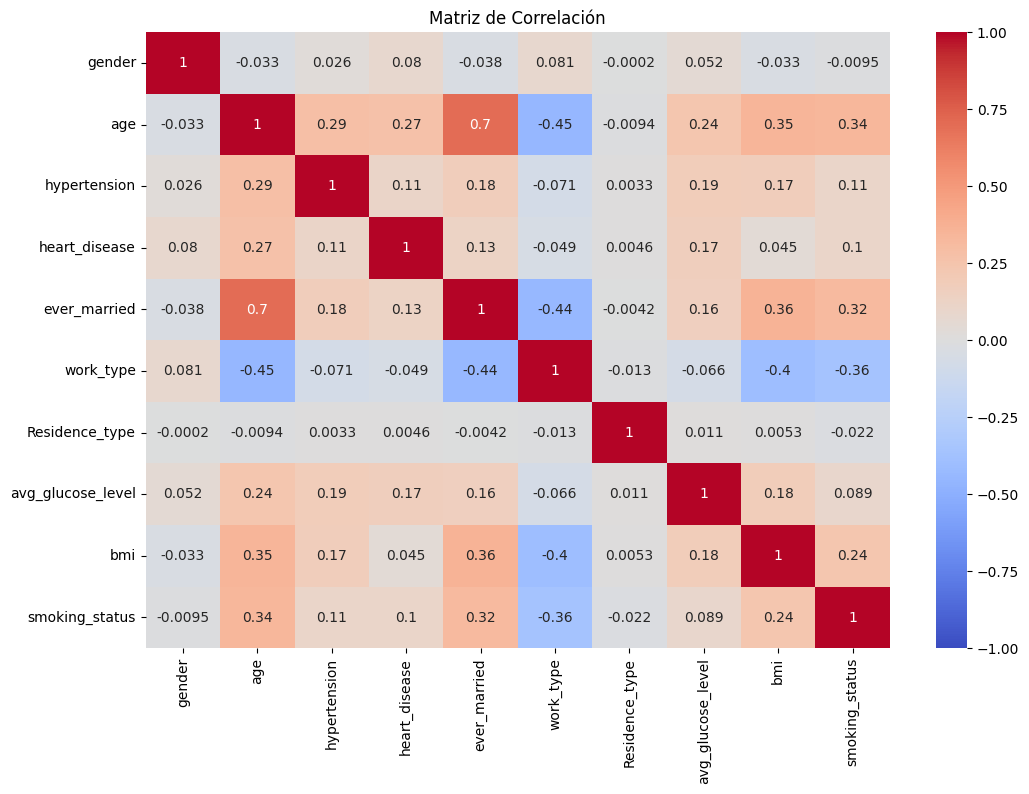

In [82]:
import seaborn as sns #Libería para visualización de datos estadísticos

matriz_correlacion = df_n.corr()
plt.figure(figsize=(12,8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1) #Mapa de calor para visualizar las correlaciones
plt.title('Matriz de Correlación')
plt.show()

In [83]:
""""X = df_n[['age', 'bmi', 'smoking_status', 'hypertension']].values
Y = df_n['stroke'].values
Y = Y.astype(int) #Conversion salida a int

def train_test_split(X, Y, test_size=1/3, random_state=None):
    if random_state:
        np.random.seed(random_state)

    #Mezclar los datos
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    Y = Y[indices]

    #Calcular tamaño del conjunto de prueba
    test_size = int(X.shape[0]*test_size)

    #Dividr los datos
    X_train, X_test = X[:-test_size], X[-test_size:]
    Y_train, Y_test = Y[:-test_size], Y[-test_size:]

    return X_train, X_test, Y_train, Y_test

#Dividr el conjunto de datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=42)



SyntaxError: incomplete input (2364559092.py, line 1)

In [85]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Extraer variables de entrada (todas las filas, todas las columnas menos la última)
# Nota que deberíamos hacer algún escalado lineal aquí
X = df_n[['age', 'bmi', 'smoking_status', 'hypertension']].values
Y = df_outputs

# Separar los datos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)

nn = MLPClassifier(solver='sgd',
                   hidden_layer_sizes=(3,2 ),
                   activation='relu',
                   max_iter=100_000,
                   learning_rate_init=.05)

nn.fit(X_train, Y_train)

# Imprimir pesos y sesgos
print(nn.coefs_)
print(nn.intercepts_)

print("Puntaje del conjunto de entrenamiento: %f" % nn.score(X_train, Y_train))
print("Puntaje del conjunto de prueba: %f" % nn.score(X_test, Y_test))

[array([[-0.04472749,  1.23032291, -0.71111733],
       [-0.07549456,  0.11796964,  0.28423986],
       [-0.02103849,  0.24654862,  0.6676913 ],
       [ 1.03567801, -0.50161044, -0.38368554]]), array([[-0.51650682, -0.35936856],
       [-0.80194445,  0.17930255],
       [ 0.63056875,  0.26634104]]), array([[-2.06670307],
       [-0.12307158]])]
[array([-0.38297758,  0.47576496, -0.68769413]), array([ 2.12822444, -0.56171716]), array([-1.52274083])]
Puntaje del conjunto de entrenamiento: 0.959327
Puntaje del conjunto de prueba: 0.954450
